# Machine Learning Engineer Nanodegree
## Reinforcement Learning
## Project: Train a Smartcab to Drive

Welcome to the fourth project of the Machine Learning Engineer Nanodegree! In this notebook, template code has already been provided for you to aid in your analysis of the *Smartcab* and your implemented learning algorithm. You will not need to modify the included code beyond what is requested. There will be questions that you must answer which relate to the project and the visualizations provided in the notebook. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide in `agent.py`.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

-----

## Getting Started
In this project, you will work towards constructing an optimized Q-Learning driving agent that will navigate a *Smartcab* through its environment towards a goal. Since the *Smartcab* is expected to drive passengers from one location to another, the driving agent will be evaluated on two very important metrics: **Safety** and **Reliability**. A driving agent that gets the *Smartcab* to its destination while running red lights or narrowly avoiding accidents would be considered **unsafe**. Similarly, a driving agent that frequently fails to reach the destination in time would be considered **unreliable**. Maximizing the driving agent's **safety** and **reliability** would ensure that *Smartcabs* have a permanent place in the transportation industry.

**Safety** and **Reliability** are measured using a letter-grade system as follows:

| Grade 	| Safety 	| Reliability 	|
|:-----:	|:------:	|:-----------:	|
|   A+  	|  Agent commits no traffic violations,<br/>and always chooses the correct action. | Agent reaches the destination in time<br />for 100% of trips. |
|   A   	|  Agent commits few minor traffic violations,<br/>such as failing to move on a green light. | Agent reaches the destination on time<br />for at least 90% of trips. |
|   B   	| Agent commits frequent minor traffic violations,<br/>such as failing to move on a green light. | Agent reaches the destination on time<br />for at least 80% of trips. |
|   C   	|  Agent commits at least one major traffic violation,<br/> such as driving through a red light. | Agent reaches the destination on time<br />for at least 70% of trips. |
|   D   	| Agent causes at least one minor accident,<br/> such as turning left on green with oncoming traffic.       	| Agent reaches the destination on time<br />for at least 60% of trips. |
|   F   	|  Agent causes at least one major accident,<br />such as driving through a red light with cross-traffic.      	| Agent fails to reach the destination on time<br />for at least 60% of trips. |

To assist evaluating these important metrics, you will need to load visualization code that will be used later on in the project. Run the code cell below to import this code which is required for your analysis.

In [11]:
# Import the visualization code
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

### Understand the World
Before starting to work on implementing your driving agent, it's necessary to first understand the world (environment) which the *Smartcab* and driving agent work in. One of the major components to building a self-learning agent is understanding the characteristics about the agent, which includes how the agent operates. To begin, simply run the `agent.py` agent code exactly how it is -- no need to make any additions whatsoever. Let the resulting simulation run for some time to see the various working components. Note that in the visual simulation (if enabled), the **white vehicle** is the *Smartcab*.

### Question 1
In a few sentences, describe what you observe during the simulation when running the default `agent.py` agent code. Some things you could consider:
- *Does the Smartcab move at all during the simulation?*
- *What kind of rewards is the driving agent receiving?*
- *How does the light changing color affect the rewards?*  

**Hint:** From the `/smartcab/` top-level directory (where this notebook is located), run the command 
```bash
'python smartcab/agent.py'
```

**Answer:**

The Smartcab is not moving at all during the simulation. 

I notice the driving agent receiving rewards based on two different states:
- Agent idled at a green light with no oncoming traffic. Approximate reward: -5 to -4
- Agent properly idled at a red light. Approximate reward: 0.1 to 2

Since the agent is idling in all situations, it is doing the right thing at red lights and receiving positive rewards, and the wrong thing at green lights and receiving negative rewards.


### Understand the Code
In addition to understanding the world, it is also necessary to understand the code itself that governs how the world, simulation, and so on operate. Attempting to create a driving agent would be difficult without having at least explored the *"hidden"* devices that make everything work. In the `/smartcab/` top-level directory, there are two folders: `/logs/` (which will be used later) and `/smartcab/`. Open the `/smartcab/` folder and explore each Python file included, then answer the following question.

### Question 2
- *In the *`agent.py`* Python file, choose three flags that can be set and explain how they change the simulation.*
- *In the *`environment.py`* Python file, what Environment class function is called when an agent performs an action?*
- *In the *`simulator.py`* Python file, what is the difference between the *`'render_text()'`* function and the *`'render()'`* function?*
- *In the *`planner.py`* Python file, will the *`'next_waypoint()`* function consider the North-South or East-West direction first?*

**Answer:**

agent.py flags:
- learning -> when True, have the agent learn from experience via Q learning.
- alpha -> this is the "learning rate" for the agent, relevant when learning = "True". The magnitude of alpha, which we keep between 0 and 1, determines the extent to which "new" rewards influence the Q-score for any state/action combination we experience. With an alpha of 1, the Q score is based solely on the latest reward; similarly, with a very high alpha, the Q score is based primarily on the latest reward. Conversely, with a very low alpha, the latest reward has a small impact on the Q score for a given state/action. I'll need to experiment with different alphas to have a sense of the practical impact of different alphas on the simulation.
- epsilon -> when learning = "True", the epsilon (which we keep between 0 and 1) during a given trial influences the % of the time that the agent picks a completely random action vs. picks the action with the highest Q score for a given state (note, if the state hasn't been encountered yet, all Q scores will be zero so it will pick a random action anyways). Higher epsilons result in random actions more often, and a random action makes it possible for us to try states that result in higher rewards than any we have already encountered, but also means the agent isn't acting on learned experience. Changing epsilon here in the flags changes its starting value, which stays constant unless we implement a decaying function. The starting value and decaying function we create will significantly impact how the agent learns and acts in response to such learnings. In Question 7, I discuss how different types of decaying functions impacted the simulation.

environment.py:
"act" is called when an agent chooses an action, accepting paramaters self, agent, and action. Quite a few things happen in this function. Among other things, this function simulates the outcome (e.g. major accident, violation, no violation) of a the action given the current state, assigns the appropriate reward (this function is called via "reward = self.env.act(self, action)"), and advances the smartcab if possible.

simulator.py: render() updates the text in the GUI, whereas render_text() updates the text in terminal.

planner.py: The relevant "if" function within next_waypoint() first considers East-West directions, and then North-South.


-----
## Implement a Basic Driving Agent

The first step to creating an optimized Q-Learning driving agent is getting the agent to actually take valid actions. In this case, a valid action is one of `None`, (do nothing) `'left'` (turn left), `right'` (turn right), or `'forward'` (go forward). For your first implementation, navigate to the `'choose_action()'` agent function and make the driving agent randomly choose one of these actions. Note that you have access to several class variables that will help you write this functionality, such as `'self.learning'` and `'self.valid_actions'`. Once implemented, run the agent file and simulation briefly to confirm that your driving agent is taking a random action each time step.

### Basic Agent Simulation Results
To obtain results from the initial simulation, you will need to adjust following flags:
- `'enforce_deadline'` - Set this to `True` to force the driving agent to capture whether it reaches the destination in time.
- `'update_delay'` - Set this to a small value (such as `0.01`) to reduce the time between steps in each trial.
- `'log_metrics'` - Set this to `True` to log the simluation results as a `.csv` file in `/logs/`.
- `'n_test'` - Set this to `'10'` to perform 10 testing trials.

Optionally, you may disable to the visual simulation (which can make the trials go faster) by setting the `'display'` flag to `False`. Flags that have been set here should be returned to their default setting when debugging. It is important that you understand what each flag does and how it affects the simulation!

Once you have successfully completed the initial simulation (there should have been 20 training trials and 10 testing trials), run the code cell below to visualize the results. Note that log files are overwritten when identical simulations are run, so be careful with what log file is being loaded!
Run the agent.py file after setting the flags from projects/smartcab folder instead of projects/smartcab/smartcab.


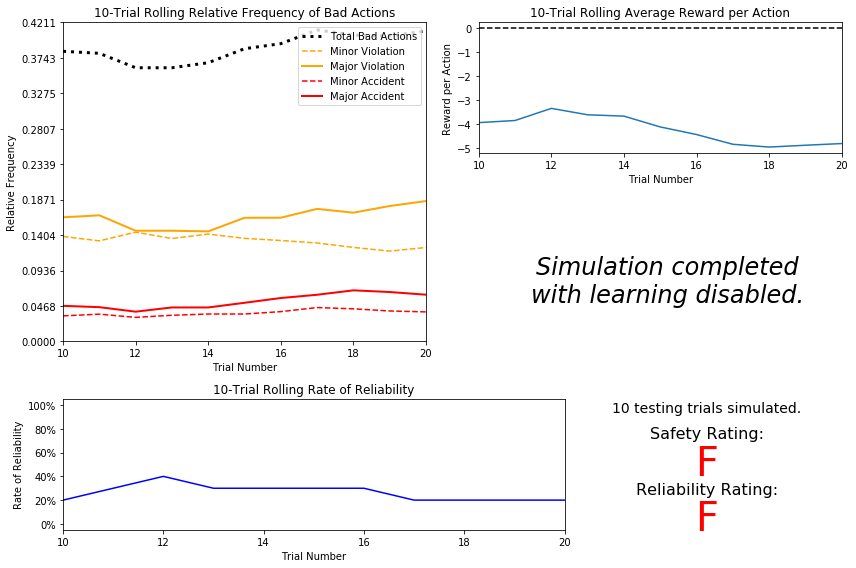

In [12]:
# Load the appropriate 'sim_no-learning' log file from the initial simulation results

vs.plot_trials('sim_no-learning.csv')

### Question 3
Using the visualization above that was produced from your initial simulation, provide an analysis and make several observations about the driving agent. Be sure that you are making at least one observation about each panel present in the visualization. Some things you could consider:
- *How frequently is the driving agent making bad decisions? How many of those bad decisions cause accidents?*
- *Given that the agent is driving randomly, does the rate of reliability make sense?*
- *What kind of rewards is the agent receiving for its actions? Do the rewards suggest it has been penalized heavily?*
- *As the number of trials increases, does the outcome of results change significantly?*
- *Would this Smartcab be considered safe and/or reliable for its passengers? Why or why not?*

**Answer:**

The agent is making bad decisions around 40% of the time, resulting in accidents ~9% of the time.

The agent reached its destination on time in 3 out of 20 trials, for a reliability rate of 15%. I'm surprised it is even this high. While random choice of the 4 actions will result in the right action 25% of the time, the 75% of incorrect actions would either delay the trip or take it off course. The deadline must be high enough that the cab has significant room for mistakes along the way.

The agent averages a reward of around -5 per action, reflecting that it is being penalized for its frequent mistakes: while it sometimes makes the right decision (approximate reward of 2) or drives the wrong way but in a harmless manner (1 to 2), it often idles when it shouldn't (-5), tries to drive through a red light (-10), or gets in a minor (-20) or major (-40) accident.

With no learning occurring, the outcome of results don't appear to change significantly in any clear direction as the number of trials increases.

This Smartcab is neither safe nor reliable, as reflected in the dual 'F' grades. It commits frequent traffic violations and accidents, and rarely gets its passengers to their destination on time.

Looking at the panels, we see that while the frequency of bad actions, the average reward, and reliability rate all fluctuate, they appear to do so randomly with no clear trend of improvement or decline. Our exploration factor epsilon and learning factor alpha remain flat at 1.0 and 0.5, per our programming.

-----
## Inform the Driving Agent
The second step to creating an optimized Q-learning driving agent is defining a set of states that the agent can occupy in the environment. Depending on the input, sensory data, and additional variables available to the driving agent, a set of states can be defined for the agent so that it can eventually *learn* what action it should take when occupying a state. The condition of `'if state then action'` for each state is called a **policy**, and is ultimately what the driving agent is expected to learn. Without defining states, the driving agent would never understand which action is most optimal -- or even what environmental variables and conditions it cares about!

### Identify States
Inspecting the `'build_state()'` agent function shows that the driving agent is given the following data from the environment:
- `'waypoint'`, which is the direction the *Smartcab* should drive leading to the destination, relative to the *Smartcab*'s heading.
- `'inputs'`, which is the sensor data from the *Smartcab*. It includes 
  - `'light'`, the color of the light.
  - `'left'`, the intended direction of travel for a vehicle to the *Smartcab*'s left. Returns `None` if no vehicle is present.
  - `'right'`, the intended direction of travel for a vehicle to the *Smartcab*'s right. Returns `None` if no vehicle is present.
  - `'oncoming'`, the intended direction of travel for a vehicle across the intersection from the *Smartcab*. Returns `None` if no vehicle is present.
- `'deadline'`, which is the number of actions remaining for the *Smartcab* to reach the destination before running out of time.

### Question 4
*Which features available to the agent are most relevant for learning both **safety** and **efficiency**? Why are these features appropriate for modeling the *Smartcab* in the environment? If you did not choose some features, why are those features* not *appropriate? Please note that whatever features you eventually choose for your agent's state, must be argued for here. That is: your code in agent.py should reflect the features chosen in this answer.
*

NOTE: You are not allowed to engineer new features for the smartcab. 

**Answer:**

Assumption:
Based on what I observe in the game, I am making the assumption that other cars on the road follow traffic and right-of-way laws (or at least that the smartcab is not punished for accidents that occur from other cars making mistakes). Note that this is not a valid assumption in the real world, but the question asks about this environment; I will revise this if the simulations or code indicate otherwise. But under this assumption, I don't need to worry about problems occurring when I follow traffic laws, such as an accident that would occur if I drove straight on a green light but the car to the right ran a red light to drive forward. 

Relevant for safety and efficiency:
- light: indicates whether we can legally and safely proceed straight or left.
- left: when at a red light, a car from the left heading straight precludes a right turn.
- oncoming: when at a green light, an oncoming car heading straight precludes a left turn.

Relevant for efficiency only:
- waypoint: dictates an appropriate direction for the agent to pursue to get closer to the destination, but it alone has no impact on safety.

Irrelevant:
- right: the car to the right's driving would affect the smartcab only in situations in which the right car drives forward through the intersection while the smartcab illegally runs a red light. In such a case, there would be an accident rather than just a violation from running the red. However, since the smartcab will already be penalized for running a red rather than doing the right thing, it should be irrelevant if the actions of another car can make things worse.
- deadline: the amount of time/actions remaining should not impact the agent's choice about the direction to move; these should be dictated by the desired destination, safety concerns, and driving regulations. However, if the reward for reaching a destination on time outweighed the penalty for infractions, then the agent might consider accepting a violation such as running a red light in order to get the passenger to its destination in a more timely manner. Thus certain reward schemes could make the deadline relevant, but I don't believe that is the case from observations thus far.

### Define a State Space
When defining a set of states that the agent can occupy, it is necessary to consider the *size* of the state space. That is to say, if you expect the driving agent to learn a **policy** for each state, you would need to have an optimal action for *every* state the agent can occupy. If the number of all possible states is very large, it might be the case that the driving agent never learns what to do in some states, which can lead to uninformed decisions. For example, consider a case where the following features are used to define the state of the *Smartcab*:

`('is_raining', 'is_foggy', 'is_red_light', 'turn_left', 'no_traffic', 'previous_turn_left', 'time_of_day')`.

How frequently would the agent occupy a state like `(False, True, True, True, False, False, '3AM')`? Without a near-infinite amount of time for training, it's doubtful the agent would ever learn the proper action!

### Question 5
*If a state is defined using the features you've selected from **Question 4**, what would be the size of the state space? Given what you know about the environment and how it is simulated, do you think the driving agent could learn a policy for each possible state within a reasonable number of training trials?*  
**Hint:** Consider the *combinations* of features to calculate the total number of states!

**Answer:**

I selected the following four features which have the following possibilities:
- waypoint: forward, left, right (3)
- light: red, green (2)
- left: None, forward, left, right (4)
- oncoming: None, forward, left, right (4)

The size of the state space is 3x2x4x4 = 96.

With 4 possible actions, there are 4x96 = 384 potential action/state possibilities.

Based on the speed the simulation is running at, this appears to be manageable number to cover within a reasonable number of training trials. If I assume for now each trial averages 15 step, then on average (if the possibilities were evenly distributed), it would take 494 steps (33 trials) to encounter all 96 states and 2,507 steps (163 trials) to encounter all 384 state/action possibilities [1]. These are just general benchmarks, as it will take some actual trials (and/or deeper analysis of the underlying code) to get a sense of a number of factors that would influence a higher or lower number of appropriate trials.

Notes:
1. Computed based on probability theory. e.g. 384/384 + 384/383 + ... + 384/1


### Update the Driving Agent State
For your second implementation, navigate to the `'build_state()'` agent function. With the justification you've provided in **Question 4**, you will now set the `'state'` variable to a tuple of all the features necessary for Q-Learning. Confirm your driving agent is updating its state by running the agent file and simulation briefly and note whether the state is displaying. If the visual simulation is used, confirm that the updated state corresponds with what is seen in the simulation.

**Note:** Remember to reset simulation flags to their default setting when making this observation!

-----
## Implement a Q-Learning Driving Agent
The third step to creating an optimized Q-Learning agent is to begin implementing the functionality of Q-Learning itself. The concept of Q-Learning is fairly straightforward: For every state the agent visits, create an entry in the Q-table for all state-action pairs available. Then, when the agent encounters a state and performs an action, update the Q-value associated with that state-action pair based on the reward received and the iterative update rule implemented. Of course, additional benefits come from Q-Learning, such that we can have the agent choose the *best* action for each state based on the Q-values of each state-action pair possible. For this project, you will be implementing a *decaying,* $\epsilon$*-greedy* Q-learning algorithm with *no* discount factor. Follow the implementation instructions under each **TODO** in the agent functions.

Note that the agent attribute `self.Q` is a dictionary: This is how the Q-table will be formed. Each state will be a key of the `self.Q` dictionary, and each value will then be another dictionary that holds the *action* and *Q-value*. Here is an example:

```
{ 'state-1': { 
    'action-1' : Qvalue-1,
    'action-2' : Qvalue-2,
     ...
   },
  'state-2': {
    'action-1' : Qvalue-1,
     ...
   },
   ...
}
```

Furthermore, note that you are expected to use a *decaying* $\epsilon$ *(exploration) factor*. Hence, as the number of trials increases, $\epsilon$ should decrease towards 0. This is because the agent is expected to learn from its behavior and begin acting on its learned behavior. Additionally, The agent will be tested on what it has learned after $\epsilon$ has passed a certain threshold (the default threshold is 0.05). For the initial Q-Learning implementation, you will be implementing a linear decaying function for $\epsilon$.

### Q-Learning Simulation Results
To obtain results from the initial Q-Learning implementation, you will need to adjust the following flags and setup:
- `'enforce_deadline'` - Set this to `True` to force the driving agent to capture whether it reaches the destination in time.
- `'update_delay'` - Set this to a small value (such as `0.01`) to reduce the time between steps in each trial.
- `'log_metrics'` - Set this to `True` to log the simluation results as a `.csv` file and the Q-table as a `.txt` file in `/logs/`.
- `'n_test'` - Set this to `'10'` to perform 10 testing trials.
- `'learning'` - Set this to `'True'` to tell the driving agent to use your Q-Learning implementation.

In addition, use the following decay function for $\epsilon$:

$$ \epsilon_{t+1} = \epsilon_{t} - 0.05, \hspace{10px}\textrm{for trial number } t$$

If you have difficulty getting your implementation to work, try setting the `'verbose'` flag to `True` to help debug. Flags that have been set here should be returned to their default setting when debugging. It is important that you understand what each flag does and how it affects the simulation! 

Once you have successfully completed the initial Q-Learning simulation, run the code cell below to visualize the results. Note that log files are overwritten when identical simulations are run, so be careful with what log file is being loaded!

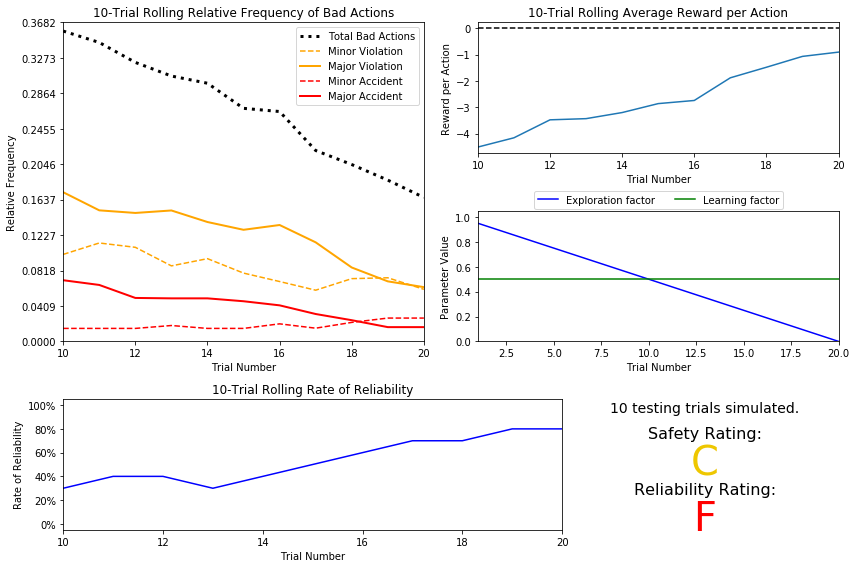

In [8]:
# Load the appropriate 'sim_default-learning' file from the default Q-Learning simulation
vs.plot_trials('sim_default-learning.csv')

##### Question 6
Using the visualization above that was produced from your default Q-Learning simulation, provide an analysis and make observations about the driving agent like in **Question 3**. Note that the simulation should have also produced the Q-table in a text file which can help you make observations about the agent's learning. Some additional things you could consider:  
- *Are there any observations that are similar between the basic driving agent and the default Q-Learning agent?*
- *Approximately how many training trials did the driving agent require before testing? Does that number make sense given the epsilon-tolerance?*
- *Is the decaying function you implemented for $\epsilon$ (the exploration factor) accurately represented in the parameters panel?*
- *As the number of training trials increased, did the number of bad actions decrease? Did the average reward increase?*
- *How does the safety and reliability rating compare to the initial driving agent?*

**Answer:**

Note: I ran this three times with all the same parameters and got (Safety, Reliability) ratings of (C, F), (F, C), and (F,F).

- Overall, the observations were dramatically different compared to the default Q-learning agent. But in terms of similarities in the panels, we see that in both cases the learning rate alpha remained flat, which is what we programmed it to do. Also, in both cases we always received at least one F grade.
- The agent required exactly 20 training trials before testing. This makes perfect sense given that we start epsilon at 1 and decrement it by 1/20 each run. This linear decline in epsilon is accurately illustrated in the parameters panel.
- As the number of training trials completed increased, the rate of bad actions decreased significantly with total bad actions occurring in 37% of the time in the first 10 trials but declining to around 17% by the last ten trials. The occurence decreased for three of the four bad actions but not for minor accidents, though this could easily be attributable to noise in the data. Accordingly, the average reward increased significantly, from -4.5 in the first 10 trials to -1 in the last 10.
- The initial driving agent received (F,F) ratings every time I ran it. As noted above, in three trials this learning agent once received a C in safety and once received a C in reliability, with all other grades as F. So while this agent is clearly superior, it is nowhere near being road-ready.


-----
## Improve the Q-Learning Driving Agent
The third step to creating an optimized Q-Learning agent is to perform the optimization! Now that the Q-Learning algorithm is implemented and the driving agent is successfully learning, it's necessary to tune settings and adjust learning paramaters so the driving agent learns both **safety** and **efficiency**. Typically this step will require a lot of trial and error, as some settings will invariably make the learning worse. One thing to keep in mind is the act of learning itself and the time that this takes: In theory, we could allow the agent to learn for an incredibly long amount of time; however, another goal of Q-Learning is to *transition from experimenting with unlearned behavior to acting on learned behavior*. For example, always allowing the agent to perform a random action during training (if $\epsilon = 1$ and never decays) will certainly make it *learn*, but never let it *act*. When improving on your Q-Learning implementation, consider the implications it creates and whether it is logistically sensible to make a particular adjustment.

### Improved Q-Learning Simulation Results
To obtain results from the initial Q-Learning implementation, you will need to adjust the following flags and setup:
- `'enforce_deadline'` - Set this to `True` to force the driving agent to capture whether it reaches the destination in time.
- `'update_delay'` - Set this to a small value (such as `0.01`) to reduce the time between steps in each trial.
- `'log_metrics'` - Set this to `True` to log the simluation results as a `.csv` file and the Q-table as a `.txt` file in `/logs/`.
- `'learning'` - Set this to `'True'` to tell the driving agent to use your Q-Learning implementation.
- `'optimized'` - Set this to `'True'` to tell the driving agent you are performing an optimized version of the Q-Learning implementation.

Additional flags that can be adjusted as part of optimizing the Q-Learning agent:
- `'n_test'` - Set this to some positive number (previously 10) to perform that many testing trials.
- `'alpha'` - Set this to a real number between 0 - 1 to adjust the learning rate of the Q-Learning algorithm.
- `'epsilon'` - Set this to a real number between 0 - 1 to adjust the starting exploration factor of the Q-Learning algorithm.
- `'tolerance'` - set this to some small value larger than 0 (default was 0.05) to set the epsilon threshold for testing.

Furthermore, use a decaying function of your choice for $\epsilon$ (the exploration factor). Note that whichever function you use, it **must decay to **`'tolerance'`** at a reasonable rate**. The Q-Learning agent will not begin testing until this occurs. Some example decaying functions (for $t$, the number of trials):

$$ \epsilon = a^t, \textrm{for } 0 < a < 1 \hspace{50px}\epsilon = \frac{1}{t^2}\hspace{50px}\epsilon = e^{-at}, \textrm{for } 0 < a < 1 \hspace{50px} \epsilon = \cos(at), \textrm{for } 0 < a < 1$$
You may also use a decaying function for $\alpha$ (the learning rate) if you so choose, however this is typically less common. If you do so, be sure that it adheres to the inequality $0 \leq \alpha \leq 1$.

If you have difficulty getting your implementation to work, try setting the `'verbose'` flag to `True` to help debug. Flags that have been set here should be returned to their default setting when debugging. It is important that you understand what each flag does and how it affects the simulation! 

Once you have successfully completed the improved Q-Learning simulation, run the code cell below to visualize the results. Note that log files are overwritten when identical simulations are run, so be careful with what log file is being loaded!

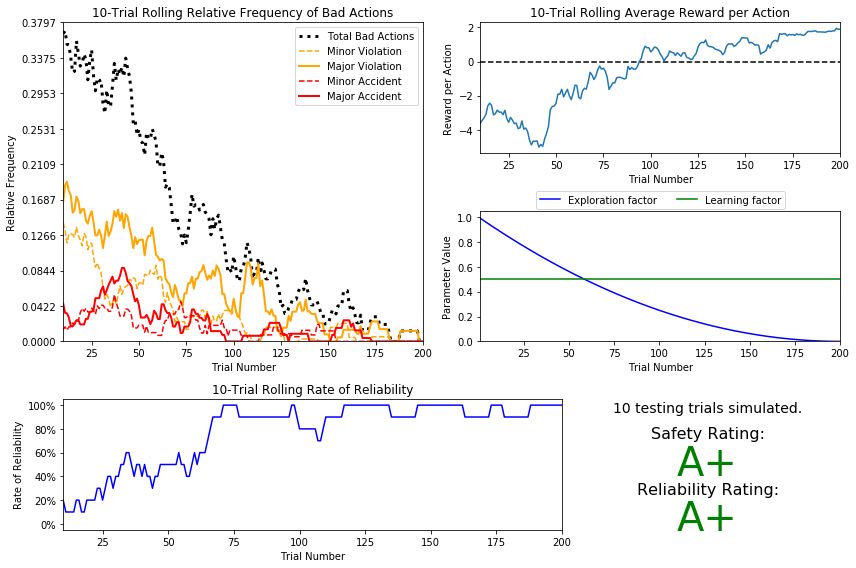

In [102]:
# Load the appropriate 'sim_improved-learning' file from the improved Q-Learning simulation
vs.plot_trials('sim_improved-learning.csv')
# eps = (200 - t)^2 / 200^2; alpha = 0.5; tolerance = .00005; 
# trial runs = 10

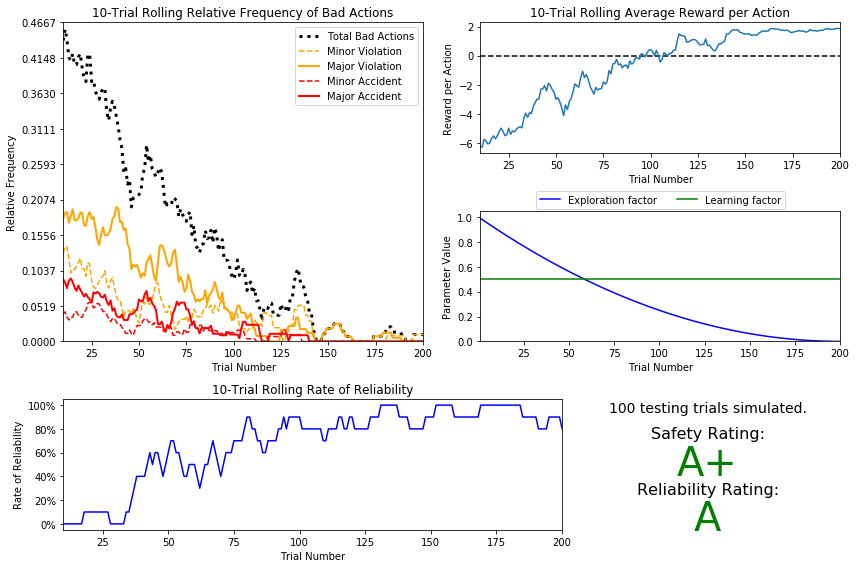

In [103]:
# Load the appropriate 'sim_improved-learning' file from the improved Q-Learning simulation
vs.plot_trials('sim_improved-learning_100.csv')
# eps = (200 - t)^2 / 200^2; alpha = 0.5; tolerance = .00005; 
# trial runs = 100

### Question 7
Using the visualization above that was produced from your improved Q-Learning simulation, provide a final analysis and make observations about the improved driving agent like in **Question 6**. Questions you should answer:  
- *What decaying function was used for epsilon (the exploration factor)?*
- *Approximately how many training trials were needed for your agent before begining testing?*
- *What epsilon-tolerance and alpha (learning rate) did you use? Why did you use them?*
- *How much improvement was made with this Q-Learner when compared to the default Q-Learner from the previous section?*
- *Would you say that the Q-Learner results show that your driving agent successfully learned an appropriate policy?*
- *Are you satisfied with the safety and reliability ratings of the *Smartcab*?*

**Answer:**

I experimented with many variants for the formula for epsilon as well as alpha and threshold values. Key observations were:
- High training volume (150-200 training runs) appears to be a necessary prerequisite for reliably high safety scores. Since a single accident during testing tanks the safety score, the agent must have a near-zero propensity for accidents, which I believe is only possible by learning in the vast majority of available states. [From my trials, it appears that high training volume can lead to reliably high safety scores for agents with a wide range of formulas and parameter values].
- The faster epsilon declines, the faster the agent transitions from experimentation to acting on learned behavior, as well as (usually) the faster safety and reliability improves in the short term. However, reliability suffers in the long term as the agent will stick with QMax actions that are positive (like safely driving stright through a green light but not toward the waypoint) rather than learning superior actions that are safe, legal, and also the optimal choice to reach the destination quickly.
- Conversely, the slower epsilon declines (all else equal), the better the long-term reliability, but the slower the agent transitions from experimentation to acting on learned behavior.

Given the above, agents performed well if the decaying function had a gradual descent, such as from 1 to 0, over the course of around 200 training runs. A linear function performed well, but I ultimately chose the quadratic function eps = (200 - t)^2 / 200^2 as it led to the agent acting on learned behavior faster, and included a final segment with an epsilon of near zero which allowed me to verify in the visualizations that reliability was approaching 100% and violations and accidents were nearing zero. I experimented with different alphas and it wasn't clear if changes in the reliability were related to the alpha or to random variation in the runs, but a moderate alpha of 0.5 appeared more reliable than a high of 0.9 or low of 0.2, so I stuck with the default alpha = 0.5. I chose a threshhold of .00001 so that epsilon would fall below the threshhold at 200 training sessions.

These changes led to dramatic improvement vis-a-vis the unoptimized Q-Learner. Given that this agent consistently achieves safety and reliability grades of A+, I believe the agent learns an appropriate policy. (Note: I usually tested with 10 trials, but the chosen function and parameters maintained A+ safety and A reliability over 100 trial runs).


### Define an Optimal Policy

Sometimes, the answer to the important question *"what am I trying to get my agent to learn?"* only has a theoretical answer and cannot be concretely described. Here, however, you can concretely define what it is the agent is trying to learn, and that is the U.S. right-of-way traffic laws. Since these laws are known information, you can further define, for each state the *Smartcab* is occupying, the optimal action for the driving agent based on these laws. In that case, we call the set of optimal state-action pairs an **optimal policy**. Hence, unlike some theoretical answers, it is clear whether the agent is acting "incorrectly" not only by the reward (penalty) it receives, but also by pure observation. If the agent drives through a red light, we both see it receive a negative reward but also know that it is not the correct behavior. This can be used to your advantage for verifying whether the **policy** your driving agent has learned is the correct one, or if it is a **suboptimal policy**.

### Question 8

1. Please summarize what the optimal policy is for the smartcab in the given environment. What would be the best set of instructions possible given what we know about the environment? 
   _You can explain with words or a table, but you should thoroughly discuss the optimal policy._

2. Next, investigate the `'sim_improved-learning.txt'` text file to see the results of your improved Q-Learning algorithm. _For each state that has been recorded from the simulation, is the **policy** (the action with the highest value) correct for the given state? Are there any states where the policy is different than what would be expected from an optimal policy?_ 

3. Provide a few examples from your recorded Q-table which demonstrate that your smartcab learned the optimal policy. Explain why these entries demonstrate the optimal policy.

4. Try to find at least one entry where the smartcab did _not_ learn the optimal policy.  Discuss why your cab may have not learned the correct policy for the given state.

Be sure to document your `state` dictionary below, it should be easy for the reader to understand what each state represents.

**Answer:** 

- If the light is red:
    - Never drive straight or left. Doing so is a major violation that can results in major accidents.
    - If turning right gets you closer to your destination than waiting for a green to drive straight or left AND there is NOT a car from the left driving forward, then turn right. (Ignoring the instructions attached to NOT's will result in accidents).
    - Otherwise, stop until the light turns green.
 
- If the light is green:
    - If straight is your optimal direction, then drive straight.
    - If left is your optimal direction, then:
        - Turn left if there is NOT an oncoming car driving forward or right.
        - Otherwise drive either straight or right depending on which gets you closer to your destination.
    - If right is your optimal direction, turn right.
    - Note that by following the instructions above you should never idle through a full green light, which is a violation.
 

Reasons the agent doesn't learn an optimal policy for a given state include:
1. It never encounters a given state.
2. It encounters a given state but doesn't try enough actions to learn which is optimal.
3. [A subset of #2]: Using Q-learning, the agent continually chooses an non-optimal action that previously yielded a positive score instead of trying the optimal action.
4. Random variation in the scoring mechanism leads to a slightly sub-optimal action having a score higher than an optimal action.

Correct Example 1:
('WP: right', 'light: red', 'left_car: right', 'oncoming_car: left')
-- forward : 0.00
-- None : 0.10
-- right : 1.29
-- left : 0.00

Advancing towards the waypoint without running a light or violating a right-of-way law is always optimal, as the agent selects to do so here with a QMax action of right.

Correct Example 2:

('WP: left', 'light: green', 'left_car: None', 'oncoming_car: right')
 -- forward : 0.87
 -- None : -3.14
 -- right : 0.97
 -- left : -14.48
 
Although the waypoint is left, the oncoming car turning right has the right of way, precluding a safe left turn. Idling would be a violation. Thus, turning right is an appropriate policy, as is driving forward.

Correct Example 3:

('WP: forward', 'light: red', 'left_car: left', 'oncoming_car: None')
 -- forward : -5.46
 -- None : 1.30
 -- right : 0.40
 -- left : -12.48

Running the red light to drive straight or left would be a violation. Driving right is not a violation, but with a waypoint of forward, taking no action and waiting for a green light is appropriate.

Incorrect Example:
('WP: right', 'light: green', 'left_car: right', 'oncoming_car: right')
 -- forward : 0.59
 -- None : 0.00
 -- right : 0.00
 -- left : 0.00
 
Here, driving forward does not result in a crash or violation, but it is sub-optimal to turning right towards the waypoint, which means it will take longer that it should to reach the destination. It is possible that the agent randomly chose forward and received a positive score, and either never encountered this state again or encountered it outside of learning mode and chose forward again since it had the highest Q score. To minimize outcomes like this (which hurt the agent's reliability), we could adjust our decay function to increase the amount of experience gained using random actions that don't consider prior Q scores.

-----
### Optional: Future Rewards - Discount Factor, `'gamma'`
Curiously, as part of the Q-Learning algorithm, you were asked to **not** use the discount factor, `'gamma'` in the implementation. Including future rewards in the algorithm is used to aid in propagating positive rewards backwards from a future state to the current state. Essentially, if the driving agent is given the option to make several actions to arrive at different states, including future rewards will bias the agent towards states that could provide even more rewards. An example of this would be the driving agent moving towards a goal: With all actions and rewards equal, moving towards the goal would theoretically yield better rewards if there is an additional reward for reaching the goal. However, even though in this project, the driving agent is trying to reach a destination in the allotted time, including future rewards will not benefit the agent. In fact, if the agent were given many trials to learn, it could negatively affect Q-values!

### Optional Question 9
*There are two characteristics about the project that invalidate the use of future rewards in the Q-Learning algorithm. One characteristic has to do with the *Smartcab* itself, and the other has to do with the environment. Can you figure out what they are and why future rewards won't work for this project?*

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.